# Augmented Reality with Planar Homographies

In [5]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [6]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames


In [107]:
def displayVid(frames):
    for frame in frames:
        cv2.imshow('Movie', frame)     
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

## Getting Correspondences

In [7]:
def find_correspondences(img1,img2,visualize=False):
    img11 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img22 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
                        
    sift = cv2.SIFT_create()
    # get keypoints and descriptors in each img
    kp1, des1 = sift.detectAndCompute(img11,None)
    kp2, des2 = sift.detectAndCompute(img22,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
 
    good = []
    for m,n in matches:
        if m.distance/n.distance < 0.65:
            # m contains queryIdx, trainIdx which correspond to the indices of the matched keypoint1,keypoint2 in their respective lists
            good.append([m])
            #print(m.queryIdx)
            #print(m.trainIdx)
            
    for i in range(len(good)):
        good[i] = sorted(good[i], key = lambda x:x.distance)
    
    img1_pts = np.float32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1,1,2)
    img2_pts = np.float32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1,1,2) 
    correspondences = [(tuple(pt1[0]), tuple(pt2[0])) for pt1, pt2 in zip(img1_pts, img2_pts)]
    
    if visualize:
        img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15,10)), plt.imshow(img3),plt.show()
    
    return img1_pts,img2_pts, correspondences
    
    

In [8]:
img1 = cv2.imread('cv_cover.jpg')
frames = loadVid('book.mov')


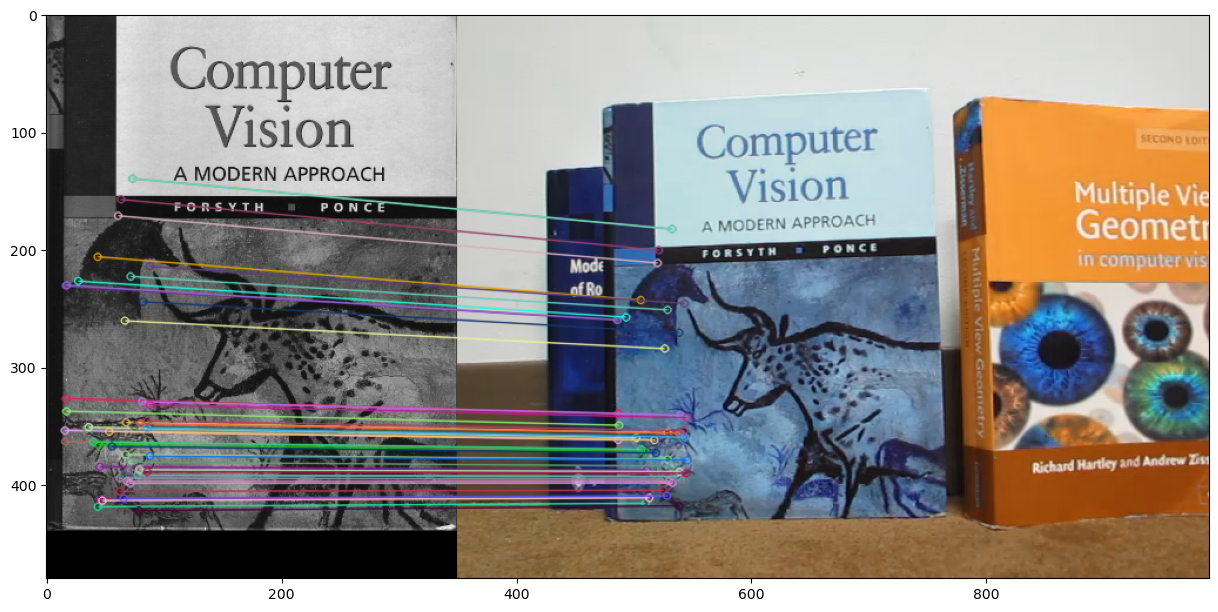

In [9]:
img1_pts,img2_pts,corr = find_correspondences(img1,frames[0],visualize=True)

## Compute the Homography Parameters

In [10]:
def compute_homography(correspondences):
    assert len(correspondences)>=4
    A = [] # 2n x 8
    b = [] # 2n x 1
    
    for ((x1,y1),(x2,y2)) in correspondences:
        A.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2])
        A.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2])
        b.append(x2), b.append(y2)
    
    H = np.linalg.lstsq(np.array(A),np.array(b),rcond=None)[0] # 8 x 1
        
    return np.append(H,1).reshape((3,3))


In [11]:
def compute_homography_ransac(img1_pts,img2_pts):
    # ransacReprojThreshold:    Maximum allowed reprojection error to treat a point pair as an inlier (set to 3.0 here)
    H, _ = cv2.findHomography(np.array(img1_pts), np.array(img2_pts), cv2.RANSAC, ransacReprojThreshold=3.0)
    return H

In [12]:
def verify_homography(img1,img2,H,correspondences):
    img1_pts = []
    img2_pts = []
    
    for ((x1,y1),(x2,y2)) in correspondences:
        pt1_homogenous = np.array([x1,y1,1])
        pt2_homogenous = np.array([x2,y2,1])
        pt1_transformed = np.matmul(H,pt1_homogenous)
        pt2_transformed = np.matmul(np.linalg.inv(H),pt2_homogenous)
        pt1_transformed_cart = (pt1_transformed[0]/pt1_transformed[2],pt1_transformed[1]/pt1_transformed[2])
        pt2_transformed_cart = (pt2_transformed[0]/pt2_transformed[2],pt2_transformed[1]/pt2_transformed[2])
        
        img1_pts.append([(x1,y1),pt2_transformed_cart])
        img2_pts.append([(x2,y2),pt1_transformed_cart])
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title("Image 1")
    for [(x1,y1),pt2_transformed_cart] in img1_pts:
        axs[0].plot(x1, y1, 'wo', markersize=3)  # Original point
        axs[0].plot(pt2_transformed_cart[0], pt2_transformed_cart[1], 'ro', markersize=2)  # Transformed point
        
    axs[1].imshow(img2)
    axs[1].set_title("Image 2")
    for [(x2,y2),pt1_transformed_cart] in img2_pts:
        axs[1].plot(x2, y2, 'wo', markersize=3)  # Original point
        axs[1].plot(pt1_transformed_cart[0], pt1_transformed_cart[1], 'ro', markersize=2)  # Transformed point
    
    plt.show()
        
        

In [13]:
H = compute_homography(corr)
H

array([[ 6.86074396e-01, -1.50175110e-02,  1.26903785e+02],
       [-1.04503935e-01,  7.26483086e-01,  8.72061430e+01],
       [-2.54501267e-04, -1.35207431e-04,  1.00000000e+00]])

In [14]:
H2 = compute_homography_ransac(img1_pts,img2_pts)
H2

array([[ 7.83468337e-01,  7.34081727e-03,  1.18320715e+02],
       [-4.75627581e-02,  7.87709823e-01,  7.63430829e+01],
       [-7.81422506e-05, -5.98336590e-05,  1.00000000e+00]])

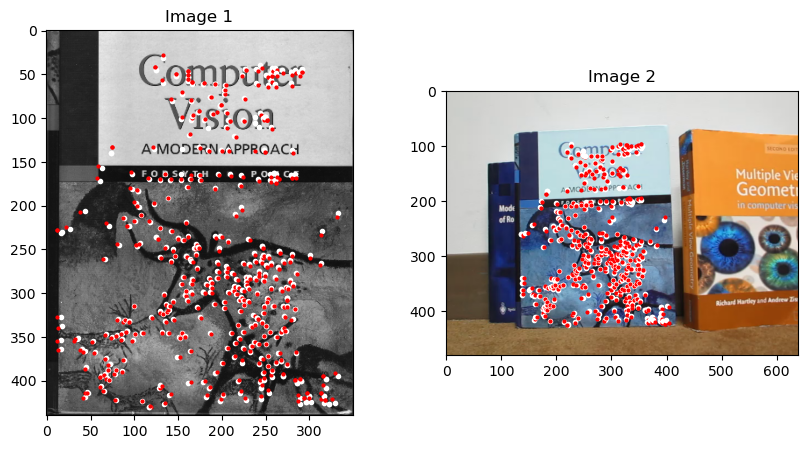

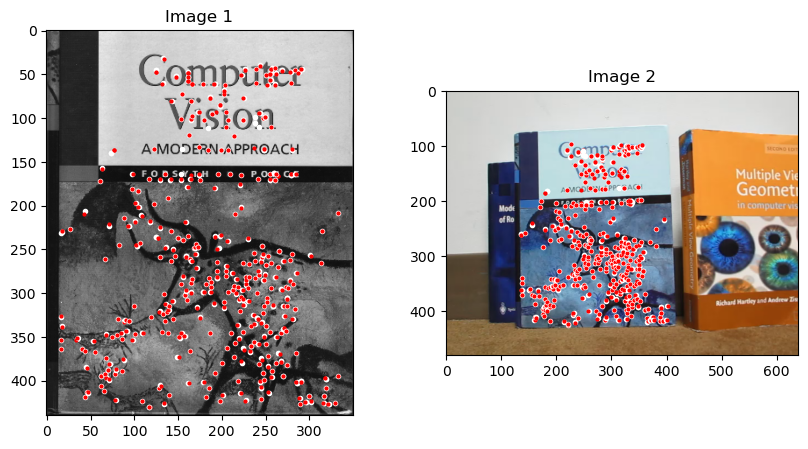

In [15]:
verify_homography(img1,frames[0],H,corr)
verify_homography(img1,frames[0],H2,corr)

## Calculate Book Coordinates

In [74]:
def compute_book_coords(img1,img2,H,visualize=False):
    
    h, w = img1.shape[:2]
    tl_homo = np.array([0,0,1]) # top left
    tr_homo = np.array([w,0,1]) # top right
    br_homo = np.array([w,h,1]) # bottom right
    bl_homo = np.array([0,h,1]) # bottom left
    
    tl_transformed = np.matmul(H,tl_homo)
    tr_transformed = np.matmul(H,tr_homo)
    br_transformed = np.matmul(H,br_homo)
    bl_transformed = np.matmul(H,bl_homo)
    
    corner1 = [tl_transformed[0]/tl_transformed[2],tl_transformed[1]/tl_transformed[2]]
    corner2 = [tr_transformed[0]/tr_transformed[2],tr_transformed[1]/tr_transformed[2]]
    corner3 = [br_transformed[0]/br_transformed[2],br_transformed[1]/br_transformed[2]]
    corner4 = [bl_transformed[0]/bl_transformed[2],bl_transformed[1]/bl_transformed[2]]
    
    corners = [corner1,corner2,corner3,corner4]
    
    if visualize:
        frame_corners = img2.copy()
        cv2.polylines(frame_corners, [np.int32(corners)], True, (0, 255, 0), 3, cv2.LINE_AA)
        plt.imshow(frame_corners),plt.show()
    
    return corners

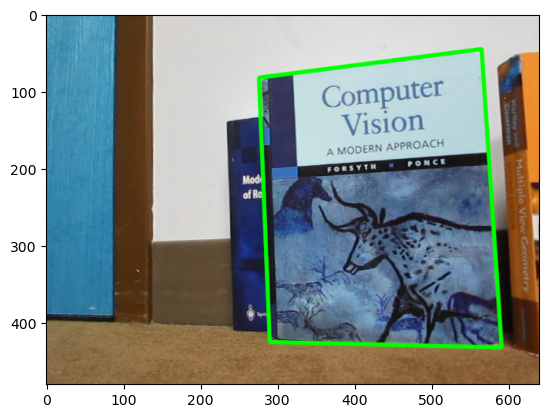

([276.566571380236, 82.29847961047874],
 [565.6979534146441, 45.32865755956665],
 [591.081759756522, 432.92075896917146],
 [290.77939298596743, 425.0869320134135])

In [48]:
compute_book_coords(img1,frames[300],visualize=True)

## Crop AR Video Frames

In [75]:
def crop_frame(ref_book,movie_frame):
    height,width = ref_book.shape[:2]

    h,w = movie_frame.shape[:2]
    mid = [w/2,h/2]
    
    # calculate the region of interest in the movie frame
    roi_start_y = max(int(mid[1] - height/2), 0)
    roi_end_y = min(int(mid[1] + height/2), h)
    roi_start_x = max(int(mid[0] - width/2), 0)
    roi_end_x = min(int(mid[0] + width/2), w)

    cropped_frame = np.zeros_like(ref_book)

    # copy the region of interest from the movie frame to the center of the cropped frame
    cropped_frame[int((height-(roi_end_y-roi_start_y))/2):int((height+(roi_end_y-roi_start_y))/2),
                  int((width-(roi_end_x-roi_start_x))/2):int((width+(roi_end_x-roi_start_x))/2)] = \
        movie_frame[roi_start_y:roi_end_y, roi_start_x:roi_end_x]
    
   
    return cropped_frame
    
    

In [83]:
def warp_frame(ref_book,book_frame,cropped_movie_frame):
    img1_pts,img2_pts,corr = find_correspondences(ref_book,book_frame)
    # H = compute_homography(corr)
    H = compute_homography_ransac(img1_pts,img2_pts)
    corners = compute_book_coords(ref_book,book_frame,H)
    
    warped_frame = np.zeros((book_frame.shape[0], book_frame.shape[1], 3), dtype='uint8')
    
    for i in range(cropped_movie_frame.shape[0]):
        for j in range(cropped_movie_frame.shape[1]):
            p = np.array([j,i,1])
            p_transformed = np.matmul(H, p)
            x_cart, y_cart = (p_transformed[0]/p_transformed[2]), (p_transformed[1]/p_transformed[2])

            if 0 < y_cart+1 < warped_frame.shape[0] and 0 < x_cart+1 < warped_frame.shape[1]:
                warped_frame[int(y_cart), int(x_cart), :] = cropped_movie_frame[i, j, :]
    
    return warped_frame,corners

## Overlay the First Frame of the Two Videos

In [81]:
def overlay(book_frame,warped_frame,corners):

    mask = cv2.fillPoly(np.ones_like(book_frame)*255, [np.int32(corners)], (0, 0, 0))
    frame = cv2.bitwise_and(book_frame, mask)
    overlayed_frame = cv2.bitwise_or(frame, warped_frame)
    return overlayed_frame
            

In [65]:
movie_frames = loadVid('ar_source.mov')

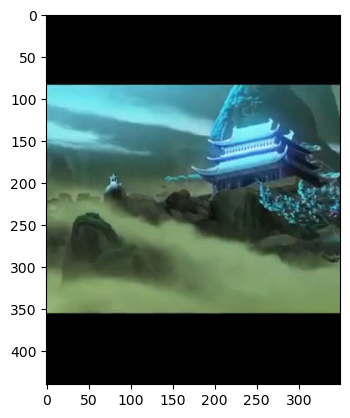

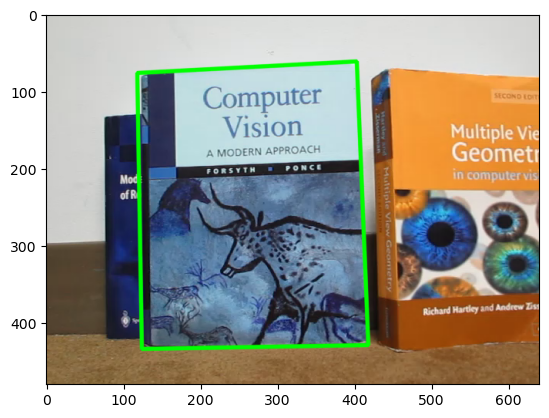

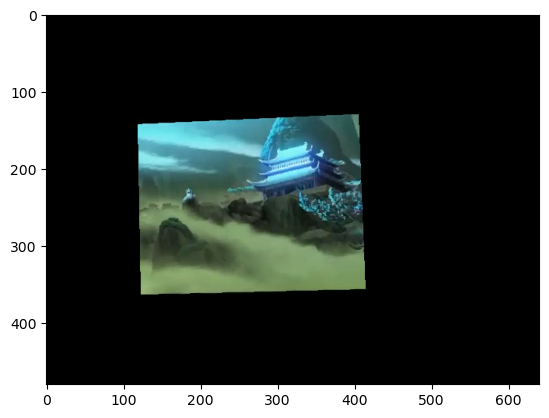

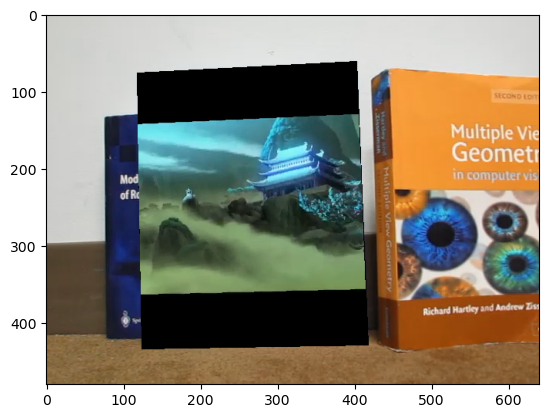

(<matplotlib.image.AxesImage at 0x7f960c783010>, None)

In [82]:
cropped_frame = crop_frame(img1,movie_frames[0])
plt.imshow(cropped_frame),plt.show()

warped_frame,corners = warp_frame(img1,frames[0],cropped_frame)
plt.imshow(warped_frame),plt.show()

overlayed_frame = overlay(frames[0],warped_frame,corners)
plt.imshow(overlayed_frame),plt.show()

## Creating AR Application

In [89]:
def warp_video(ref_book,book_frames,movie_frames):
    overlayed_frames=[]
    for i in range(len(book_frames)):
        if i >= len(movie_frames):
            break
        cropped_frame = crop_frame(ref_book,movie_frames[i])
        warped_frame,corners = warp_frame(ref_book,book_frames[i],cropped_frame)
        overlayed_frames.append(overlay(book_frames[i],warped_frame,corners))
    return overlayed_frames

In [90]:
overlayed_frames = warp_video(img1,frames,movie_frames)


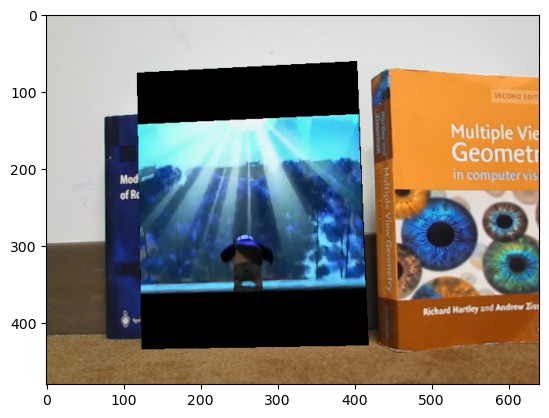

(<matplotlib.image.AxesImage at 0x7f960c783a60>, None)

In [105]:
plt.imshow(overlayed_frames[10]),plt.show()

In [109]:
displayVid(overlayed_frames)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObject::moveToThread: Current thread (0x7f961025a800) is not the object's thread (0x3794d80).
Cannot move to target thread (0x7f961025a800)

QObjec